In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.model_selection import train_test_split
from  sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.decomposition import PCA

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


<b> Import data From Data Wrangling Notebook</b>

In [0]:
data_df = pd.read_csv("/content/gdrive/My Drive/Data/dataformodel.csv")

<li>Preview of Data frame</li>

In [0]:
data_df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Actor_Gender_code,Emotion_code,Emotional_intensity_code,Gender_label,Emotion_label,Intensity_label,x,y,cluster
0,-726.217274,68.541416,3.293398,12.205299,5.510278,13.667407,-2.983828,3.098029,-3.310813,-1.564385,-7.861652,-2.124282,2.849204,-2.667807,0.959020,1.628166,-2.736689,0.254240,2.675377,-1.761166,1,1,1,Male,neutral,normal,2.442386,-0.006188,1
1,-719.127814,70.202235,1.169072,13.123214,7.837617,14.411951,-4.110705,4.469618,-3.538731,-3.657982,-7.647889,-1.476476,3.032409,-2.461295,0.595291,0.978989,-2.835643,0.074318,1.759796,-2.062723,1,1,1,Male,neutral,normal,2.381119,-0.167988,1
2,-714.994923,69.690371,3.925558,11.925323,6.423344,11.014113,-2.874455,4.514386,-4.470306,-2.665094,-7.492452,-2.955175,1.880886,-2.905068,0.533953,1.381326,-2.356382,-2.012536,1.609709,-1.555485,1,1,1,Male,neutral,normal,2.074745,-0.356189,1
3,-759.917816,75.788948,6.028997,14.562724,6.459431,14.636640,-2.999553,4.625813,-5.195350,-0.702962,-7.786034,-3.560928,2.184742,-1.828897,-0.347037,0.832212,-2.520894,-0.658892,2.920049,-1.937435,1,2,1,Male,calm,normal,2.678436,-0.721646,1
4,-735.006568,79.093059,8.141061,11.413559,5.174133,15.393293,-2.752062,2.964593,-5.388962,-1.691822,-5.852824,-4.043277,3.004653,-1.036605,-0.067745,0.088225,-2.209569,-1.455965,2.568243,-1.596300,1,2,1,Male,calm,normal,2.597002,-0.685411,1


<li> Create functions to aid with the modelling </li>

In [0]:
### Label encoder to code the labels
def label_encoding(target):
  le = LabelEncoder().fit(target)
  le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
  print(le_name_mapping)
  return le.transform(target),le_name_mapping

### Split the Data set into Train andtest
def split(X,y,test_size=0.3,shuffle=True):
  return train_test_split(X,y,test_size=test_size,stratify=y,shuffle=shuffle)


### Function to Opimize Hyperparameters using cross validation
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=10,verbose=3,scoring="accuracy",return_train_score=True):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print ("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    ### data Frame to get results of grid search CV
    results = pd.DataFrame(gs.cv_results_)
    return best,results

  
### Scale The data set using Standard scaler  
def scale(x):
  z_scaler = sklearn.preprocessing.StandardScaler()
  return z_scaler.fit_transform(x)  


### Test performance with accuracy score
def preformance(predicted,ytest):
  print(accuracy_score(ytest,predicted))
  
  
### Create data Frame with mean score for each fold:
def splittestscores(columns,df):
  my_dict = {}
  for cl in columns:
    my_dict[cl]=df[cl].mean()
  return my_dict  
    
    
  
  



  
  
  #skplt.metrics.plot_confusion_matrix(ytest,predicted, normalize=False)
  #plt.show()

<b> ------------------------------------Predict Gender and Emotion from data ----------------------------------------------------------</b>

<li> Create X and y, first I try to predict <b>Gender</b> from the data </li>

In [0]:
predictors=data_df.iloc[:,0:20].values
label = data_df['Gender_label']

<li> Scale the predictors and encode the labels</li>

In [0]:
X = scale(predictors)
y,map= label_encoding(label)

{'Female': 0, 'Male': 1}


<li> Split the data set </li>

In [0]:
Xtrain, Xtest, ytrain, ytest = split(X,y)

In [0]:
print(f'Shape of Xtrain is {Xtrain.shape}')
print(f'Shape of Xtest is {Xtest.shape}')
print(f'Shape of ytrain is {ytrain.shape}')
print(f'Shape of ytest is {ytest.shape}')

Shape of Xtrain is (1008, 20)
Shape of Xtest is (432, 20)
Shape of ytrain is (1008,)
Shape of ytest is (432,)


<li> Set Parametets for Random Forest to use in the "CV optimize"function which uses 5 fold cross validation and Gridsearch CV from sklearn to give the best parameter for the best fitting model </li>

In [0]:
clf = RandomForestClassifier(random_state=42)
#param_grid = {"n_estimators": np.arange(10, 100, 10),"max_depth": np.arange(1, 28, 1),"min_samples_split": np.arange(10,150,10),"min_samples_leaf": np.arange(1,20,1),"max_leaf_nodes": np.arange(2,20,1),"min_weight_fraction_leaf": np.arange(0.1,0.4, 0.1),"max_features":['auto',None,'sqrt']}

<li>  I chose the following parameters for the CV optmize function,
  <b>n_estimators</b> is the number of trees to be used in the forest. Since Random Forest is an ensemble method comprising of creating multiple decision trees, this parameter is used to control the number of trees to be used in the process.</li>

<li>  <b>max_features</b>on the other hand, determines the maximum number of features to consider while looking for a split. </li>

 <li>If “auto”, then max_features=sqrt(n_features)</li>
 <li>If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).</li>
 <li>If “log2”, then max_features=log2(n_features).</li>
  <li>If None, then max_features=n_features.</li>
  
  
  <li><b> max_depth </b>is the maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.</li>
 
  

In [0]:
param_grid = {"n_estimators": np.arange(10, 150, 10),
              "max_depth": np.arange(1, 15, 1),
              "max_features":['auto',None,'sqrt']}

In [0]:
model,result_df = cv_optimize(clf,param_grid,Xtrain,ytrain)

BEST PARAMS {'max_depth': 9, 'max_features': 'auto', 'n_estimators': 80}


<b> Mean test score for each folds</b>

In [0]:
splittestscores(result_df.columns[8:18].values,result_df)

{'split0_test_score': 0.8990096038415376,
 'split1_test_score': 0.9423769507803119,
 'split2_test_score': 0.9219521141790025,
 'split3_test_score': 0.9443944244364485,
 'split4_test_score': 0.9133843537414921,
 'split5_test_score': 0.964710884353744,
 'split6_test_score': 0.9207993197278891,
 'split7_test_score': 0.9596258503401431,
 'split8_test_score': 0.9164625850340091,
 'split9_test_score': 0.9648639455782401}

<li> Test performance </li>

In [0]:
ypred = model.predict(Xtest)

preformance(ypred,ytest)

0.9606481481481481


<li> Plot the confusion matrix </li>

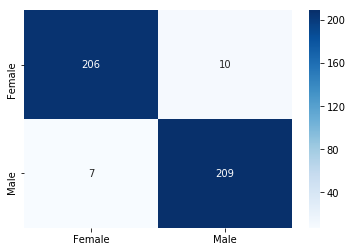

In [0]:
cm = confusion_matrix(ytest, ypred)
matrix_df = pd.DataFrame(cm,index=['Female','Male'],columns=['Female','Male'])
_=sns.heatmap(matrix_df,annot=True,fmt='g',cmap='Blues')

<b> prediction for emotion labels</b>
<li> using emotion as label </li>

In [0]:
label2 = data_df['Emotion_label']

## Enode label 2
yemo = label_encoding(label2)

{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


In [0]:
### Split data using the same predictors 


Xemo_train,Xemo_test,yemo_train,yemo_test = split(X,yemo)

In [0]:
param_grid2 = {"n_estimators": np.arange(10, 100, 10),
              "max_depth": np.arange(1, 15, 1),
              "max_features":['auto',None,'sqrt']}

In [0]:
#### Using same parameters call cv_optimize function to get tuned parameters

model2,result_df2 = cv_optimize(clf,param_grid2,Xemo_train,yemo_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


BEST PARAMS {'max_depth': 14, 'max_features': 'auto', 'n_estimators': 90}


<b> Mean test score for each folds</b>

In [0]:
#splittestscores(result_df2.columns[8:18].values,result_df2)

<li> Test Performance </li>

In [0]:
yemo_pred = model2.predict(Xemo_test)

preformance(yemo_pred,yemo_test)

0.6319444444444444


<li> Plot confusion matrix</li>

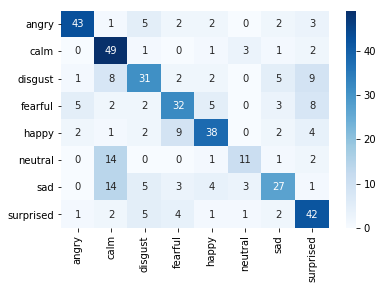

In [0]:
cm1 = confusion_matrix(yemo_test, yemo_pred)
matrix_df1 = pd.DataFrame(cm1,index=['angry','calm','disgust','fearful','happy','neutral','sad','surprised'],columns=['angry','calm','disgust','fearful','happy','neutral','sad','surprised'])
_=sns.heatmap(matrix_df1,annot=True,fmt='g',cmap='Blues')

<b> -------------------Test Performance with joining the labels of emotion and Gender------------------</b> 

In [0]:
#### Create new label for Gender_emotion
data_df['Gender_emotion']=data_df['Gender_label']+data_df['Emotion_label']

<b> Distribution of each Label</b>

In [0]:
data_df['Gender_emotion'].value_counts()

Malehappy          96
Femalecalm         96
Femaledisgust      96
Femalefearful      96
Femalesad          96
Femaleangry        96
Femalehappy        96
Malesurprised      96
Maleangry          96
Femalesurprised    96
Malecalm           96
Malefearful        96
Malesad            96
Maledisgust        96
Femaleneutral      48
Maleneutral        48
Name: Gender_emotion, dtype: int64

<b> prediction for emotion by gender labels</b>


In [0]:
### Create Label
label3 = data_df['Gender_emotion']
###
yemobygender,mapping = label_encoding(label3)

{'Femaleangry': 0, 'Femalecalm': 1, 'Femaledisgust': 2, 'Femalefearful': 3, 'Femalehappy': 4, 'Femaleneutral': 5, 'Femalesad': 6, 'Femalesurprised': 7, 'Maleangry': 8, 'Malecalm': 9, 'Maledisgust': 10, 'Malefearful': 11, 'Malehappy': 12, 'Maleneutral': 13, 'Malesad': 14, 'Malesurprised': 15}


In [0]:
### Split data using the same predictors 


Xemobygender_train,Xemobygender_test,yemobygender_train,yemobygender_test = split(X,yemobygender)

In [0]:
#### Using same parameters call cv_optimize function to get tuned parameters

model3,result_df3 = cv_optimize(clf,param_grid2,Xemobygender_train,yemobygender_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


BEST PARAMS {'max_depth': 13, 'max_features': 'auto', 'n_estimators': 80}


<b> Mean test score for each folds</b>

In [0]:
splittestscores(result_df3.columns[8:18].values,result_df3)

{'split0_test_score': 0.4764400519117509,
 'split1_test_score': 0.4449435958869918,
 'split2_test_score': 0.4190875511630227,
 'split3_test_score': 0.43758111210941386,
 'split4_test_score': 0.4247812372812376,
 'split5_test_score': 0.4336080586080588,
 'split6_test_score': 0.4397130647130646,
 'split7_test_score': 0.42227398205659145,
 'split8_test_score': 0.42954144620811313,
 'split9_test_score': 0.4057613168724275}

<b>check Performance</b>

In [0]:
yemobygender_pred = model2.predict(Xemobygender_test)

preformance(yemobygender_pred,yemobygender_test)

0.4305555555555556


<b> ----------------------------Feature selection using PCA and test permormance   -------------------------------------------</b>

<b> Perform Feature variance analysis using PCA </b>

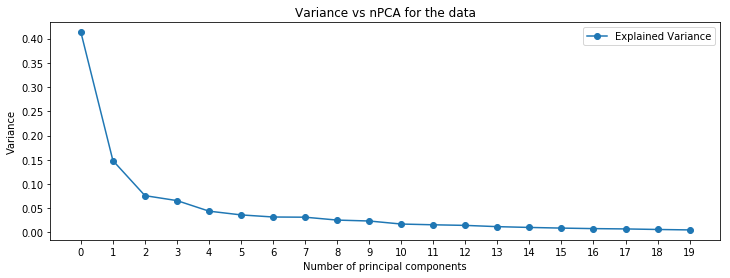

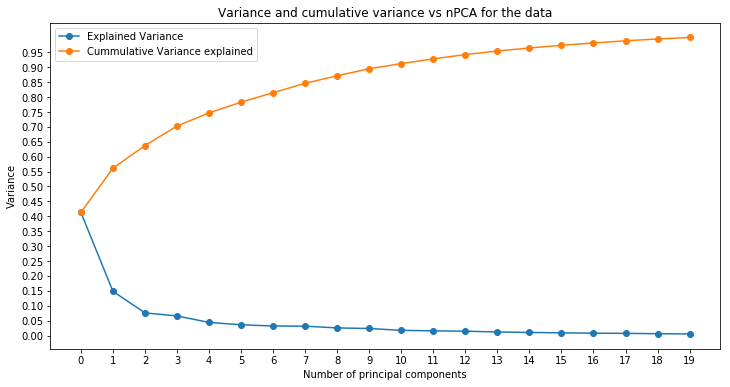

In [0]:
plt.figure(figsize=(12, 4))
scaled_data=scale(data_df.iloc[:,0:20].values)
pca_feature = PCA().fit(scaled_data)
plt.plot(pca_feature.explained_variance_ratio_,marker='o',label='Explained Variance')
#plt.plot(pca_feature.explained_variance_.cumsum(), marker='o',label='Cummulative Variance explained')
plt.legend()
plt.ylabel('Variance')
plt.xlabel('Number of principal components')
plt.title('Variance vs nPCA for the data')
_=plt.xticks(np.arange(0, 20, step=1))

plt.show()

plt.figure(figsize=(12, 6))
plt.plot(pca_feature.explained_variance_ratio_,marker='o',label='Explained Variance')
plt.plot(pca_feature.explained_variance_ratio_.cumsum(), marker='o',label='Cummulative Variance explained')
plt.legend()
plt.ylabel('Variance')
plt.xlabel('Number of principal components')
plt.title('Variance and cumulative variance vs nPCA for the data')

_=plt.xticks(np.arange(0, 20, step=1))
_=plt.yticks(np.arange(0, 1, step=.05))

plt.show()

<li> We can see that 13 Features contribute to 95% of the variance </li>
<li> test model Performace with only 13 features</li>

<b> ------------------------------Test Model Performance for 13 features for predicting Gender-----------------------------------------</b>

In [0]:
### Scale data and create predict label
xr = scale(data_df.iloc[:,:13].values)
yr,mapr = label_encoding(data_df['Gender_label'])


{'Female': 0, 'Male': 1}


In [0]:
Xr_train,Xr_test,yr_train,yr_test = split(xr,yr)
print(f'Shape of Xtrain is {Xr_train.shape}')
print(f'Shape of Xtest is {Xr_test.shape}')
print(f'Shape of ytrain is {yr_train.shape}')
print(f'Shape of ytest is {yr_test.shape}')
model4,result_df4 = cv_optimize(clf,param_grid,Xr_train,yr_train)

Shape of Xtrain is (1008, 13)
Shape of Xtest is (432, 13)
Shape of ytrain is (1008,)
Shape of ytest is (432,)
BEST PARAMS {'max_depth': 9, 'max_features': 'auto', 'n_estimators': 90}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
yr_pred = model4.predict(Xr_test)

preformance(yr_pred,yr_test)

0.9537037037037037


<li> Scores of all individual CV test</li>

In [0]:
splittestscores(result_df4.columns[8:18].values,result_df4)

{'split0_test_score': 0.9485127384287104,
 'split1_test_score': 0.9151660664265718,
 'split2_test_score': 0.9236027744431071,
 'split3_test_score': 0.9193844204348384,
 'split4_test_score': 0.9221598639455771,
 'split5_test_score': 0.9270918367346928,
 'split6_test_score': 0.901649659863949,
 'split7_test_score': 0.8929251700680275,
 'split8_test_score': 0.9008333333333349,
 'split9_test_score': 0.8889965986394591}

<b> ------------------------------Test Model Performance for 13 features for predicting Emotions-----------------------------------------</b>

In [0]:
yremo,mapr = label_encoding(data_df['Emotion_label'])
Xremo_train,Xremo_test,yremo_train,yremo_test = split(xr,yremo)
model5,result_df5 = cv_optimize(clf,param_grid,Xremo_train,yremo_train)

{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


BEST PARAMS {'max_depth': 14, 'max_features': 'auto', 'n_estimators': 120}


In [0]:
yremo_pred = model5.predict(Xremo_test)

preformance(yremo_pred,yremo_test)

0.5370370370370371


<li> Scores of all individual CV test</li>

In [0]:
splittestscores(result_df5.columns[8:18].values,result_df5)

{'split0_test_score': 0.40950761256883683,
 'split1_test_score': 0.510592808551992,
 'split2_test_score': 0.4095076125688376,
 'split3_test_score': 0.46154842889536796,
 'split4_test_score': 0.44101501986933506,
 'split5_test_score': 0.40823268082743425,
 'split6_test_score': 0.4639212827988316,
 'split7_test_score': 0.43193772354302556,
 'split8_test_score': 0.45835963251279827,
 'split9_test_score': 0.4424398625429557}

<b>  Implement Clustering to analyse underlying groups (or "clusters") in the data set for predicting emotions and see if we can group labels together to achieve a better Performing model</b>

In [0]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster
samples = scale(predictors)
labels_encode,map= label_encoding(data_df['Emotion_label'])


{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


<li> Create heirarchial clusters visualization </li>

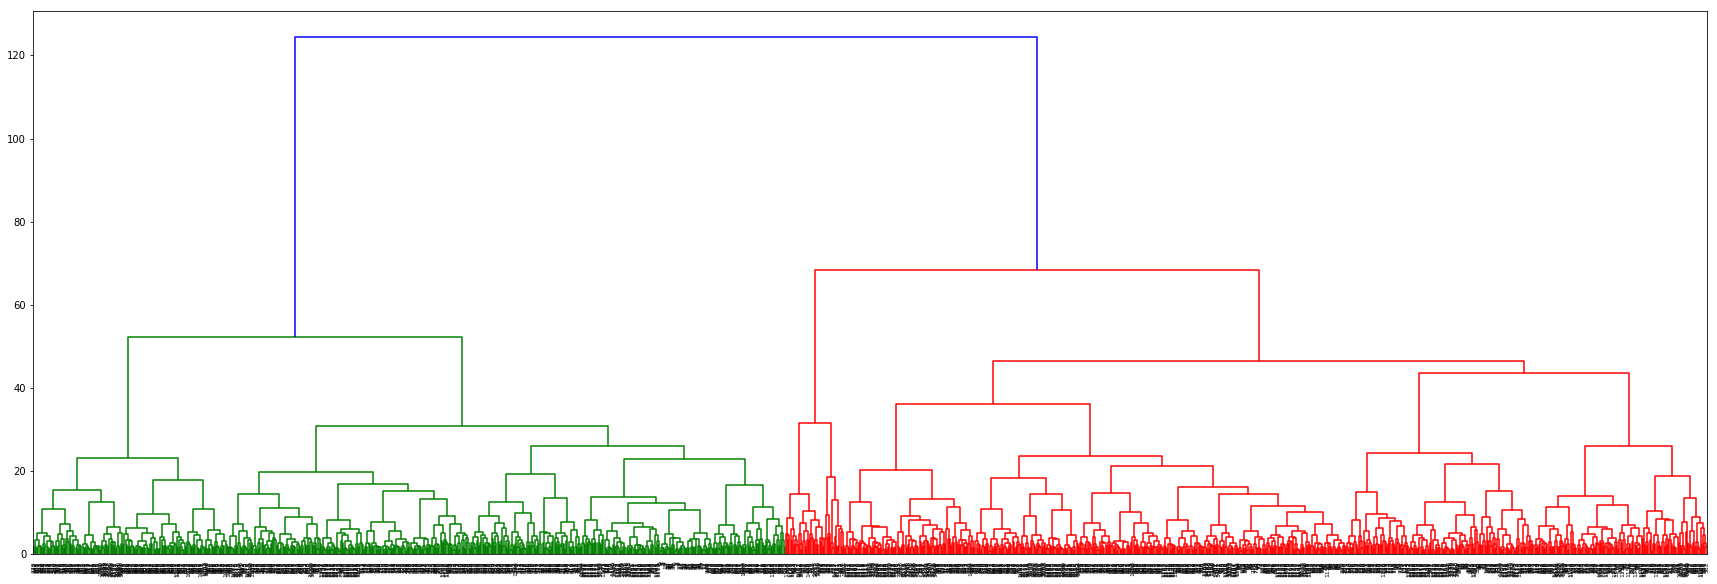

In [0]:
plt.figure(figsize=(30,10))
mergings = linkage(samples,method='ward')
dendrogram(mergings,leaf_rotation=90,leaf_font_size=6,no_labels=False)
plt.show()


<li> Plot Truncated plot to Help in analysis I am truncating only the last 10 Merged clusters</li>

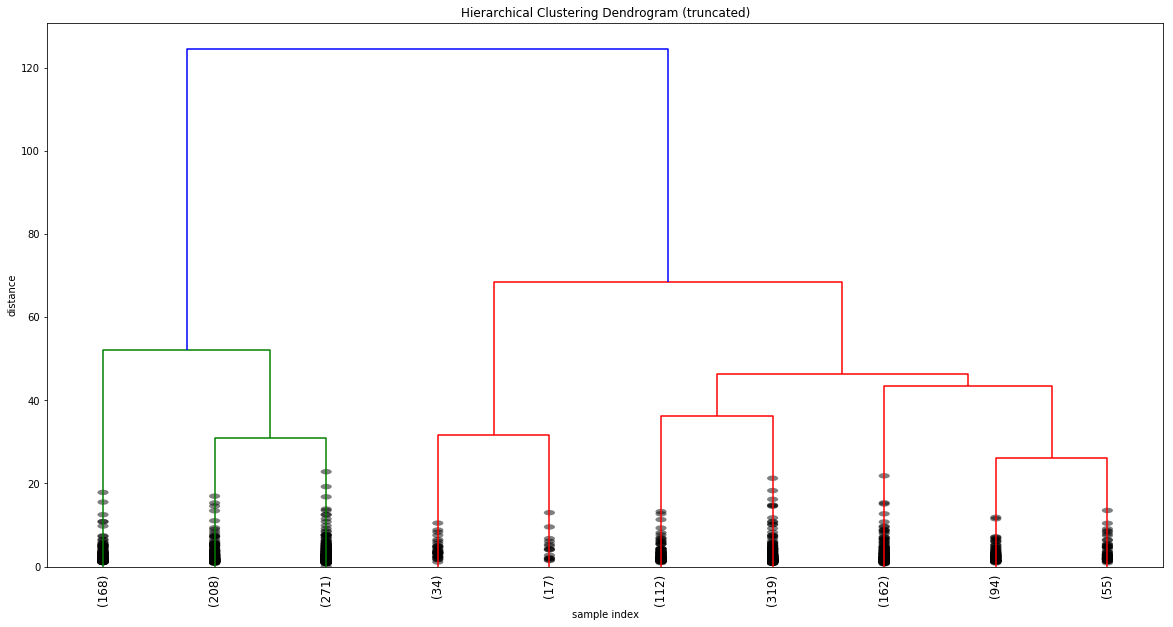

In [0]:
plt.figure(figsize=(20,10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    mergings,labels=data_df['Emotion_label'].values,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=10,  # show only the last p merged clusters
    show_leaf_counts=True,  #  numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
#plt.axhline(y=11, c='r',linestyle = '--')
plt.show()


<b> Selecting a Distance Cut-Off/ Determining the Number of Clusters</b>
<li> Visually looking at it we see a spike in the height of clustering at 49 , drawing a line to cut the Y axis and couting the intersection with the line we see 6 clusters  </li>

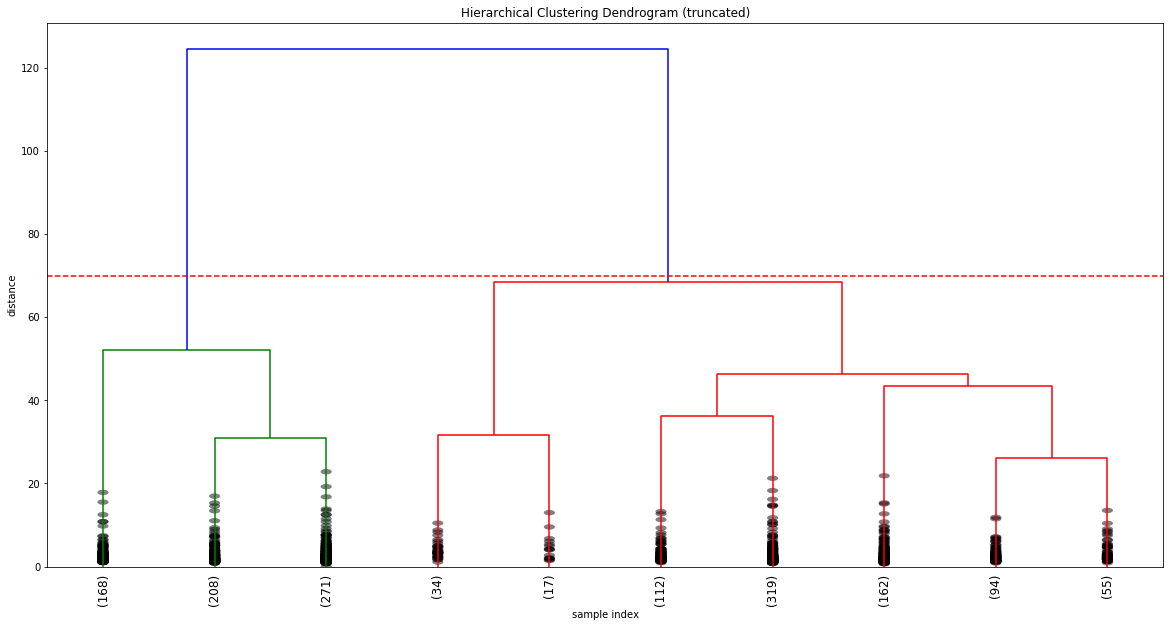

In [0]:
plt.figure(figsize=(20,10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    mergings,labels=data_df['Emotion_label'].values,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=10,  # show only the last p merged clusters
    show_leaf_counts=True,  #  numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.axhline(y=70, c='r',linestyle = '--')
plt.show()


<b> Extract Cluster labels with 49 as the height/distance </b>

In [0]:
clusters = fcluster(mergings,70,criterion='distance')
data_df['cluster']=clusters

<li>Plot clusters in  2d with PCA</li>

<b> Inspect cluster labels</b>

In [0]:

df_cluster = pd.DataFrame({'emotion_label':data_df['Emotion_label'].values,'clusters':clusters})

In [0]:
pd.crosstab(df_cluster['clusters'],df_cluster['emotion_label'])

emotion_label,angry,calm,disgust,fearful,happy,neutral,sad,surprised
clusters,,,,,,,,
1,63,104,96,75,73,53,101,82
2,129,88,96,117,119,43,91,110


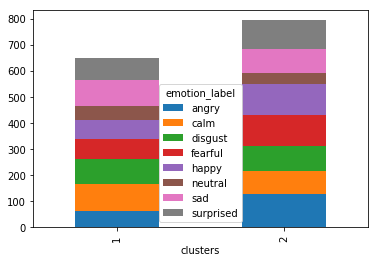

In [0]:
_=pd.crosstab(df_cluster['clusters'],df_cluster['emotion_label']).plot.bar(stacked=True)

In [0]:
data_df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Actor_Gender_code,Emotion_code,Emotional_intensity_code,Gender_label,Emotion_label,Intensity_label,x,y,cluster
0,-726.217274,68.541416,3.293398,12.205299,5.510278,13.667407,-2.983828,3.098029,-3.310813,-1.564385,-7.861652,-2.124282,2.849204,-2.667807,0.959020,1.628166,-2.736689,0.254240,2.675377,-1.761166,1,1,1,Male,neutral,normal,2.442386,-0.006188,1
1,-719.127814,70.202235,1.169072,13.123214,7.837617,14.411951,-4.110705,4.469618,-3.538731,-3.657982,-7.647889,-1.476476,3.032409,-2.461295,0.595291,0.978989,-2.835643,0.074318,1.759796,-2.062723,1,1,1,Male,neutral,normal,2.381119,-0.167988,1
2,-714.994923,69.690371,3.925558,11.925323,6.423344,11.014113,-2.874455,4.514386,-4.470306,-2.665094,-7.492452,-2.955175,1.880886,-2.905068,0.533953,1.381326,-2.356382,-2.012536,1.609709,-1.555485,1,1,1,Male,neutral,normal,2.074745,-0.356189,1
3,-759.917816,75.788948,6.028997,14.562724,6.459431,14.636640,-2.999553,4.625813,-5.195350,-0.702962,-7.786034,-3.560928,2.184742,-1.828897,-0.347037,0.832212,-2.520894,-0.658892,2.920049,-1.937435,1,2,1,Male,calm,normal,2.678436,-0.721646,1
4,-735.006568,79.093059,8.141061,11.413559,5.174133,15.393293,-2.752062,2.964593,-5.388962,-1.691822,-5.852824,-4.043277,3.004653,-1.036605,-0.067745,0.088225,-2.209569,-1.455965,2.568243,-1.596300,1,2,1,Male,calm,normal,2.597002,-0.685411,1


In [0]:
data_df['Gender_emotion'] = data_df['Gender_label']+data_df['Emotion_label']

<b>--------------------------- Heirarchial Clustering for Gender Emotion------------------<b>

In [0]:
male_df = data_df.loc[data_df['Gender_label']=='Male',:]
Female_df = data_df.loc[data_df['Gender_label']=='Female',:]
predictors_male = male_df.iloc[:,0:20].values
predictors_female = Female_df.iloc[:,0:20].values

{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


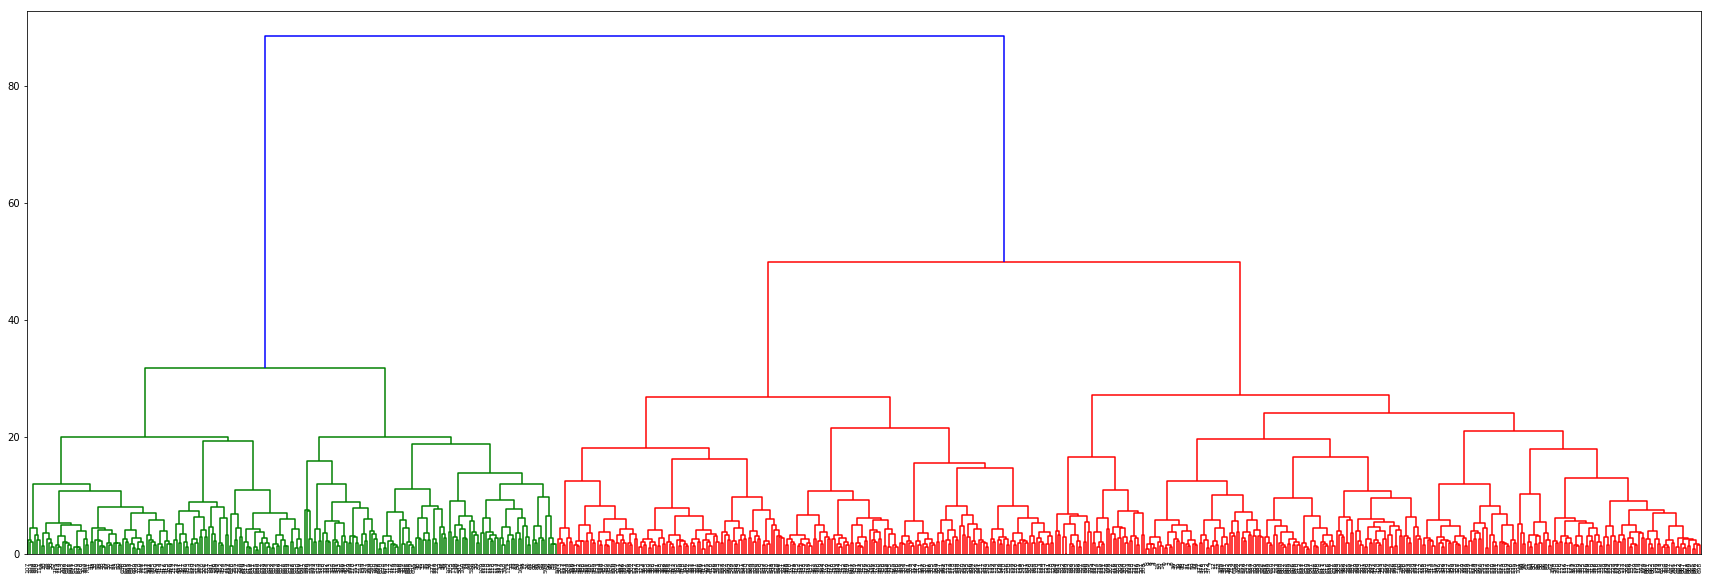

In [0]:
samples = scale(predictors_male)
labels_encode,map= label_encoding(male_df['Emotion_label'])
plt.figure(figsize=(30,10))
mergings = linkage(samples,method='ward')
dendrogram(mergings,leaf_rotation=90,leaf_font_size=6,no_labels=False)
plt.show()


In [0]:
clusters = fcluster(mergings,70,criterion='distance')
male_df.loc[:,'clusters']=clusters
#df_cluster_male = pd.DataFrame({'emotion_label':male_df.loc[:,'Emotion_label'].values,'clusters':male_df['clusters']})
#pd.crosstab(df_cluster_male['clusters'],df_cluster['emotion_label'])


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [0]:
male_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Actor_Gender_code,Emotion_code,Emotional_intensity_code,Gender_label,Emotion_label,Intensity_label,x,y,cluster,Gender_emotion
0,-726.217274,68.541416,3.293398,12.205299,5.510278,13.667407,-2.983828,3.098029,-3.310813,-1.564385,-7.861652,-2.124282,2.849204,-2.667807,0.959020,1.628166,-2.736689,0.254240,2.675377,-1.761166,1,1,1,Male,neutral,normal,2.442386,-0.006188,2,Maleneutral
1,-719.127814,70.202235,1.169072,13.123214,7.837617,14.411951,-4.110705,4.469618,-3.538731,-3.657982,-7.647889,-1.476476,3.032409,-2.461295,0.595291,0.978989,-2.835643,0.074318,1.759796,-2.062723,1,1,1,Male,neutral,normal,2.381119,-0.167988,2,Maleneutral
2,-714.994923,69.690371,3.925558,11.925323,6.423344,11.014113,-2.874455,4.514386,-4.470306,-2.665094,-7.492452,-2.955175,1.880886,-2.905068,0.533953,1.381326,-2.356382,-2.012536,1.609709,-1.555485,1,1,1,Male,neutral,normal,2.074745,-0.356189,2,Maleneutral
3,-759.917816,75.788948,6.028997,14.562724,6.459431,14.636640,-2.999553,4.625813,-5.195350,-0.702962,-7.786034,-3.560928,2.184742,-1.828897,-0.347037,0.832212,-2.520894,-0.658892,2.920049,-1.937435,1,2,1,Male,calm,normal,2.678436,-0.721646,2,Malecalm
4,-735.006568,79.093059,8.141061,11.413559,5.174133,15.393293,-2.752062,2.964593,-5.388962,-1.691822,-5.852824,-4.043277,3.004653,-1.036605,-0.067745,0.088225,-2.209569,-1.455965,2.568243,-1.596300,1,2,1,Male,calm,normal,2.597002,-0.685411,2,Malecalm
